# Quick overview of rhdf5client/restfulSE in HDF Kita

We'll start by taking a look at the 1.3 million neuron dataset from 10x genomics

In [1]:
suppressPackageStartupMessages({
    library(rhdf5client)
})

In [2]:
packageVersion("rhdf5client") # should be at least 1.3.13

[1] '1.3.13'

In [3]:
d10x = H5S_Array(URL_hsds(), "/shared/bioconductor/tenx_full.h5", "newassay001")
d10x

<27998 x 1306127> H5S_Matrix object of type "double":
               [,1]       [,2]       [,3] ... [,1306126] [,1306127]
    [1,]          0          0          0   .          0          0
    [2,]          0          0          0   .          0          0
    [3,]          0          0          0   .          0          0
    [4,]          0          0          0   .          0          0
    [5,]          0          0          0   .          0          0
     ...          .          .          .   .          .          .
[27994,]          0          0          0   .          0          0
[27995,]          1          0          0   .          0          0
[27996,]          0          0          0   .          0          0
[27997,]          0          0          0   .          0          0
[27998,]          0          0          0   .          0          0

In [4]:
t(apply(d10x[,1:10], 2, sum))

4046,2087,4654,3193,8444,11178,2375,3672,3115,4592


# Binding metadata to the assay

We have a helper function in the restfulSE package that connects gene and
sample annotation to these quantifications.

In [5]:
#.libPaths(c("R-lib", .libPaths()))
#.libPaths()

In [6]:
suppressPackageStartupMessages({
    library(restfulSE)
    library(SummarizedExperiment)
})
se10x = se1.3M()
assays(se10x) = SimpleList(counts=d10x) # will not be necessary in future

analyzing groups for their links...
done
snapshotDate(): 2018-09-20
see ?restfulSEData and browseVignettes('restfulSEData') for documentation
downloading 0 resources
loading from cache 
    '/Users/stvjc//.ExperimentHub/1656'


In [7]:
se1.3M

function (url = "http://h5s.channingremotedata.org:5000", tag = "tenx_full") 
{
    ds = H5S_Array(endpoint = url, filepath = "", host = tag)
    ehub = ExperimentHub::ExperimentHub()
    tag = names(AnnotationHub::query(ehub, "full_1Mneurons"))
    full_1Mneurons = ehub[[tag[1]]]
    assays(full_1Mneurons) = SimpleList(counts = ds)
    full_1Mneurons
}
<bytecode: 0x7f80ff087b00>
<environment: namespace:restfulSE>

In [8]:
se10x

class: SummarizedExperiment 
dim: 27998 1306127 
metadata(0):
assays(1): counts
rownames(27998): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000096730 ENSMUSG00000095742
rowData names(12): ensid seqnames ... symbol entrezid
colnames(1306127): AAACCTGAGATAGGAG-1 AAACCTGAGCGGCTTC-1 ...
  TTTGTCAGTTAAAGTG-133 TTTGTCATCTGAAAGA-133
colData names(4): Barcode Sequence Library Mouse

In [9]:
# str(assay(se10x))  # to check internals

In [10]:
t(apply(assay(se10x[,1:4]),2,sum))

AAACCTGAGATAGGAG-1,AAACCTGAGCGGCTTC-1,AAACCTGAGGAATCGC-1,AAACCTGAGGACACCA-1
4046,2087,4654,3193


In [11]:
dim(rowData(se10x))
head(rowData(se10x))

[1] 27998    12

DataFrame with 6 rows and 12 columns
                                ensid seqnames     start       end     width
                          <character> <factor> <integer> <integer> <integer>
ENSMUSG00000051951 ENSMUSG00000051951        1   3205901   3671498    465598
ENSMUSG00000089699 ENSMUSG00000089699        1   3466587   3513553     46967
ENSMUSG00000102343 ENSMUSG00000102343        1   3905739   3986215     80477
ENSMUSG00000025900 ENSMUSG00000025900        1   4290846   4409241    118396
ENSMUSG00000109048 ENSMUSG00000109048       NA        NA        NA        NA
ENSMUSG00000025902 ENSMUSG00000025902        1   4490931   4497354      6424
                     strand            gene_id    gene_name   gene_biotype
                   <factor>        <character>  <character>    <character>
ENSMUSG00000051951        - ENSMUSG00000051951         Xkr4 protein_coding
ENSMUSG00000089699        + ENSMUSG00000089699       Gm1992      antisense
ENSMUSG00000102343        - ENSMUSG00000102343 

# An example in human glioblastoma

The BiocOncoTK package includes a dataset quantifying gene expression using
single-cell RNA-seq on a collection of tumors.

In [12]:
suppressPackageStartupMessages(library(BiocOncoTK))

In [13]:
cdar = BiocOncoTK::darmGBMcls
cdar

class: RangedSummarizedExperiment 
dim: 65218 3584 
metadata(1): source
assays(1): count_lstpm
rownames(65218): ENSG00000000003.14 ENSG00000000005.5 ... ERCC-00170
  ERCC-00171
rowData names(3): gene genome symbol
colnames(3584): GSM2243439 GSM2243440 ... GSM2247076 GSM2247077
colData names(59): title geo_accession ... tsne.cluster.ch1 well.ch1

In [14]:
options(repr.plot.height=3)

The following code uses density estimates on log10(read count+1) to how the distribution of CD45 varies by asserted cell type.

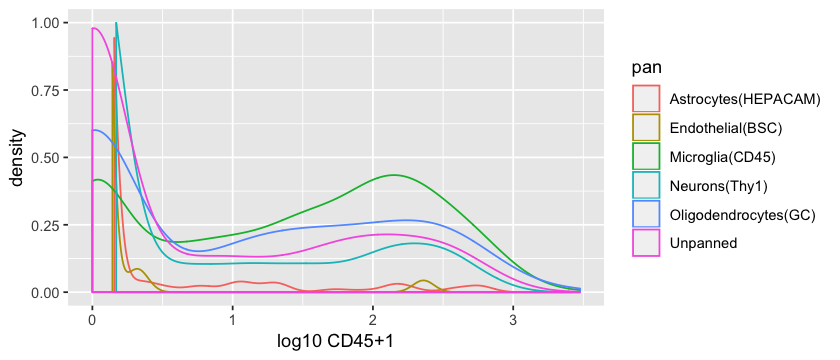

In [15]:
library(ggplot2)
cdar = BiocOncoTK::darmGBMcls
ind = match("PTPRC", rowData(cdar)$symbol)
var = gsub("selection: ", "",
       cdar$characteristics_ch1.8)
vals = log10(as.numeric(assay(cdar[ind,])+1))
ddd = data.frame(log10norm=vals, pan=var)
ggplot(ddd, aes(x=log10norm, colour=pan)) +
  geom_density() + ylim(0,1) +
  xlab("log10 CD45+1")